# Description
This is a jupyter notebook to analyze the data of the PTB-XL database of ECG measurements.


In [1]:
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

from utils.loading import load_signal_and_annotations, load_diagnostic_aggregation
from utils.plotting import plot_ecg_signal
from utils.preprocessing import butter_bandpass_filter, smooth_signal, normalize_signal
from utils.ecg_signal_analysis import find_peaks, find_heartbeat_peaks, find_qrs_complex


## Constants
Defining some constants that will be re-used throughout the script

In [2]:
path = './data/physionet.org/files/ptb-xl/1.0.2/'
sampling_rate = 100
channels = ["I", "II", "III", "AVL", "AVR", "AVF", "V1", "V2", "V3", "V4", "V5", "V6"]

## Data Loading
We load the data with functions that are based on the script provided in the dataset (´example_physionet.py´).
To get a general overview the size and available information of the loaded dataset is printed.

In [3]:
X, Y = load_signal_and_annotations(sampling_rate, path)
# Y = load_diagnostic_aggregation(path, Y)

print('Loaded ECG data files: ' + str(len(X)))
print('Loaded annotation files: ' + str(len(Y['patient_id'])))
print('Available annotation information:')
print(list(Y.columns))

Loaded ECG data files: 21801
Loaded annotation files: 21801
Available annotation information:
['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'validated_by_human', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr', 'r_peaks', 'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH', 'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC', 'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL']


# Signal Plotting for Diagnosis
We plot the signal such that doctors could use it for diagnosis.
The patient id can be specified.
The format in clinics is usually standardized to grids where each square corresponds to 0.2s in width and 0.5 mV in height.
We output the format correspondingly. The Figure has a high resolution so with zoom it can be analyzed better.

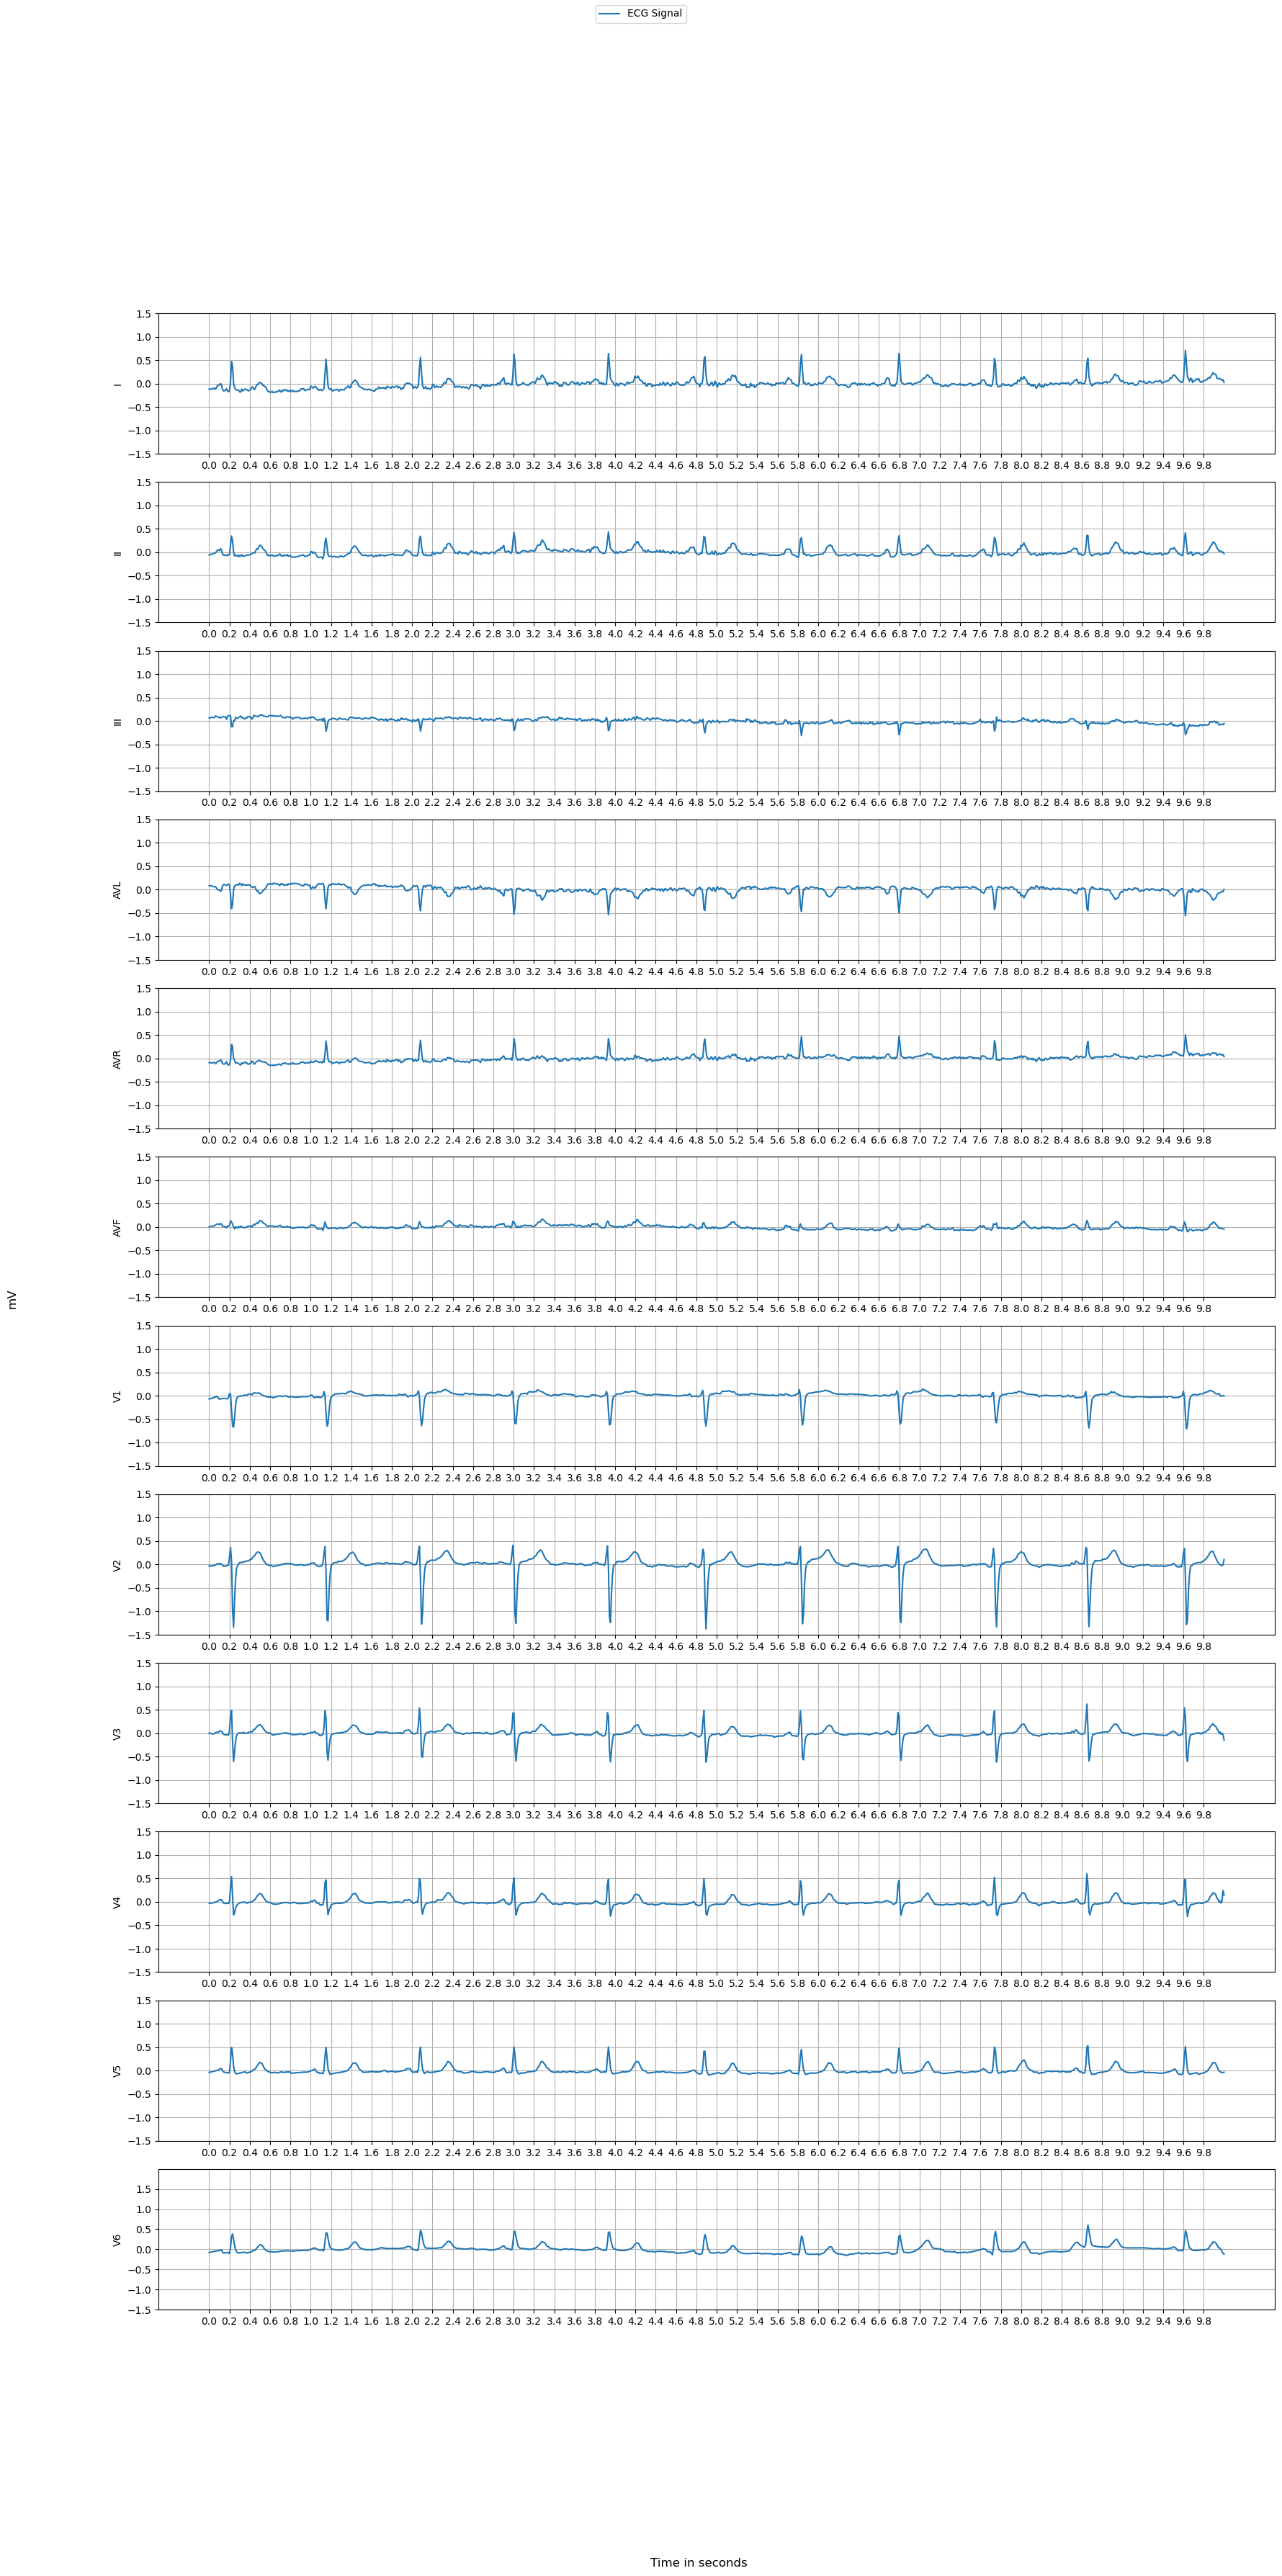

In [4]:
patient_id = 0
plot_ecg_signal(X[patient_id, :, :], channels=channels, sampling_rate=sampling_rate)

# Preprocessing
There are several ways to preprocess the signal. Here we make sure to remove the baseline drift (shift of the baseline signal up or down) and high frequency noise.

In [ ]:
patient_id = 0

X_preprocessed = butter_bandpass_filter(X, filter_freq=0.6, order=3)
X_preprocessed = smooth_signal(X_preprocessed)
X_preprocessed = normalize_signal(X_preprocessed)
plot_ecg_signal(X_preprocessed[patient_id, :, :], channels=channels, sampling_rate=sampling_rate)


In [ ]:
print(X_preprocessed.shape)

# Heart Beat Estimation
The heart rate can best be assessed with lead II (source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1122339/)


Plan: Write quick and dirty code for heart rate estimation
Define Neural Network for predictions

In [ ]:
patient_id = 0
peaks = find_peaks(X_preprocessed[patient_id,:,:])
heartbeat, heartbeat_peaks = find_heartbeat_peaks(peaks)

failed_detection = False
if len(heartbeat) < 6:
    failed_detection = True

if not failed_detection:
    print('Number of estimated heartbeats: ' + str(len(heartbeat)))
    print('Average heart beat frequency: ' + str(60*len(heartbeat)/10) + ' beats/min')
    plot_ecg_signal(X[patient_id, :, :], channels=channels, sampling_rate=sampling_rate, 
                    heartbeats=heartbeat, heartbeat_peaks=heartbeat_peaks)
else:
    print('Signal is not clear enough for automatic detection.')

## Mark QRS complex
Now we want to detect and highlight the QRS complex. 
More information can be found here: https://ecgwaves.com/ecg-qrs-complex-q-r-s-wave-duration-interval/
We use the detected heartbeat peaks ('R-wave') and the slopes to the left and right of it to find the QRS complex. The algorithm searches for a 'valley' on the left and right (Q and S wave) and the following plateau.
The QRS complex is plotted in yellow.

In [ ]:




qrs_start_median, qrs_end_median = find_qrs_complex(X_preprocessed[patient_id,:,:], heartbeat, heartbeat_peaks)
plot_ecg_signal(X[patient_id, :, :], channels=channels, sampling_rate=sampling_rate, 
                heartbeats=heartbeat, heartbeat_peaks=heartbeat_peaks, qrs_intervals = (qrs_start_median, qrs_end_median))


